# 資管四 唐瑋廷 B05705043 Hw5

## Q1 (90%):

### Load the dataset

In [1]:
import pickle
with open('msd_full.pickle', 'rb') as f:
    data = pickle.load(f)
    X_train, Y_train = data['X_train'], data['Y_train']
    X_test, Y_test = data['X_test'], data['Y_test']
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(463715, 90) (463715,)
(51630, 90) (51630,)


### Stardardize dataset

In [2]:
train_mean, train_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

### De-mean

In [3]:
y_mean = Y_train.mean()
Y_train_demean, Y_test_demean = Y_train - y_mean, Y_test - y_mean

### Split train data into validation and subtraining

In [4]:
X_valid, Y_valid, Y_valid_demean = X_train[:X_train.shape[0]//10], Y_train[:Y_train.shape[0]//10], Y_train_demean[:Y_train.shape[0]//10]
X_subtrain, Y_subtrain, Y_subtrain_demean = X_train[X_train.shape[0]//10:], Y_train[Y_train.shape[0]//10:], Y_train_demean[Y_train.shape[0]//10:]
print(X_subtrain.shape, X_valid.shape)

(417344, 90) (46371, 90)


### RMSE

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
def rmse(t, p):
    return sqrt(mean_squared_error(t, p))

### OLS
#### keep	10,000	Linear Regression	None

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
reg = LinearRegression(n_jobs=-1).fit(X_subtrain[:10000], Y_subtrain[:10000])
predict = reg.predict(X_test)
err = rmse(Y_test, predict)

print(f'rmse: {err}')

rmse: 9.558013246155223


### MLP_0_dm
#### de-mean	10,000	MLP, no hidden layers	None

In [31]:
import mxnet as mx
from mxnet import autograd, init, nd
from mxnet.gluon import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, bs, wd=None, early_stop=True):
    
    dataset = mx.gluon.data.dataset.ArrayDataset(mx.ndarray.array(train_features), mx.ndarray.array(train_labels))
    dataloader = mx.gluon.data.DataLoader(dataset, batch_size=bs, shuffle=True)
    trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd, 'grad_clip': 2}) if wd else mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    loss = mx.gluon.loss.L2Loss()
    
    best_err = 10000
    stop_cnt = 0
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(dataloader):
            x = x.as_in_context(mx.gpu())
            y = y.as_in_context(mx.gpu())
            with autograd.record():
                l = loss(net(x), y)
            l.backward()
            trainer.step(bs)
        
        train_err = rmse(train_labels, net(mx.ndarray.array(train_features, ctx=mx.gpu())).asnumpy())
        val_err = rmse(test_labels, net(mx.ndarray.array(test_features, ctx=mx.gpu())).asnumpy())
        train_ls.append(train_err)
        test_ls.append(val_err)

        print(f'epoch {epoch+1}, loss: {val_err}', end='\r')

        stop_cnt += 1
        if val_err < best_err:
            best_err = val_err
            stop_cnt = 0
            net.save_parameters('best.params')

        if stop_cnt == 50 and early_stop:
            print(f'Early break! Best validation error: {best_err} at epoch {epoch+1}')
            net.load_parameters('best.params', ctx=mx.gpu())
            break
            
    return train_ls, test_ls


In [11]:
lrs = [5e-3, 1e-2, 2e-2, 5e-2]

Early break! Best validation error: 9.588867053300614 at epoch 122


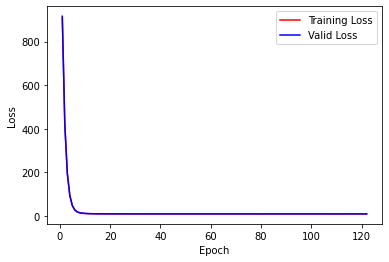

Early break! Best validation error: 9.592368564316967 at epoch 127


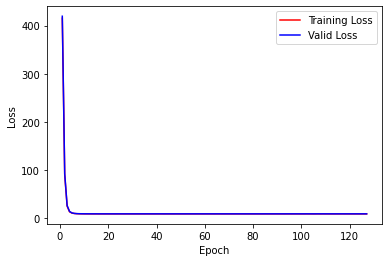

Early break! Best validation error: 9.604814332367008 at epoch 140


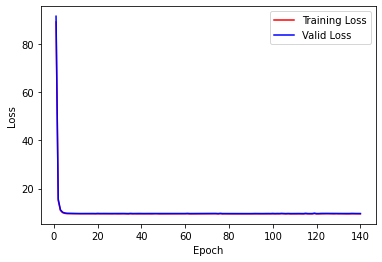

Early break! Best validation error: 9.645867196462715 at epoch 106


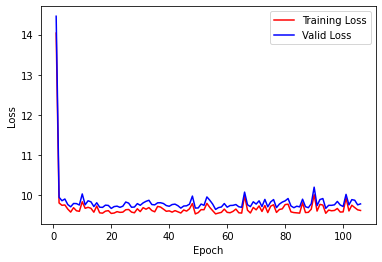

test rmse: 9.553136340078291


In [35]:
best_err = 10000
for lr in lrs:
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
    train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain[:10000], X_valid, Y_valid, 3000, lr, 64)
    
    if min(valid_loss) < best_err:
        best_err = min(valid_loss)
        test_rmse = rmse(Y_test, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())
        
    epoch_count = range(1, len(train_loss) + 1)
    
    plt.plot(epoch_count, train_loss, 'r-')
    plt.plot(epoch_count, valid_loss, 'b-')
    plt.legend(['Training Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

print(f'test rmse: {test_rmse}')

### MLP_1_dm
#### de-mean	10,000	MLP, one hidden layer + ReLU	None

Early break! Best validation error: 9.204450474153665 at epoch 62


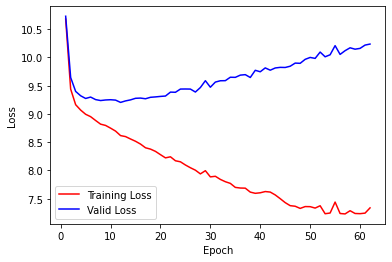

Early break! Best validation error: 9.236187104408629 at epoch 55


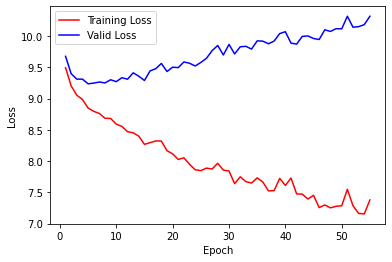

Early break! Best validation error: 9.2577205038013 at epoch 54


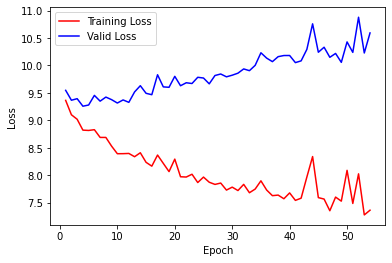

Early break! Best validation error: 9.414773651033045 at epoch 54


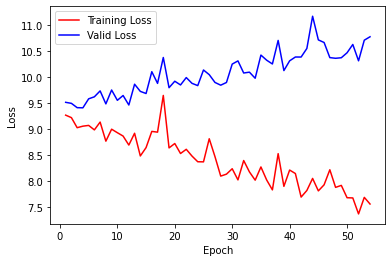

test rmse: 9.245884554471074


In [36]:
best_err = 10000
for lr in lrs:
    net = nn.Sequential()
    net.add(nn.Dense(45, activation="relu"))
    net.add(nn.Dense(1))
    net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
    train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain_demean[:10000], X_valid, Y_valid_demean, 3000, lr, 64)
    
    if min(valid_loss) < best_err:
        best_err = min(valid_loss)
        test_rmse = rmse(Y_test_demean, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())
        
    epoch_count = range(1, len(train_loss) + 1)
    
    plt.plot(epoch_count, train_loss, 'r-')
    plt.plot(epoch_count, valid_loss, 'b-')
    plt.legend(['Training Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_dm
#### de-mean	10,000	MLP, two hidden layers + ReLu	None

Early break! Best validation error: 9.167253580019704 at epoch 62


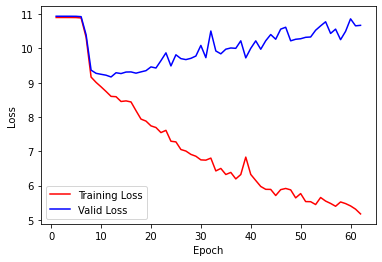

Early break! Best validation error: 9.234361864328946 at epoch 58


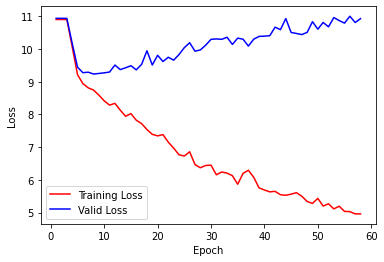

Early break! Best validation error: 9.24761331004244 at epoch 55


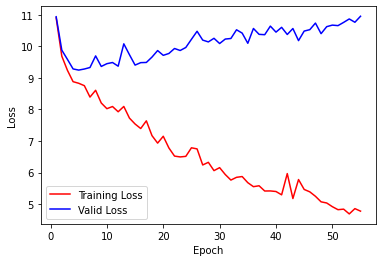

Early break! Best validation error: 9.498245769524255 at epoch 58


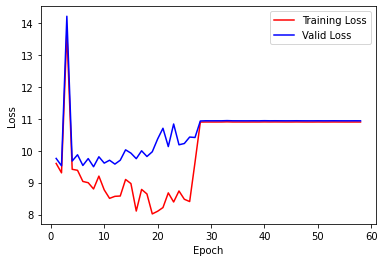

test rmse: 9.215631217997048


In [38]:
best_err = 10000
for lr in lrs:
    net = nn.Sequential()
    net.add(nn.Dense(45, activation="relu"))
    net.add(nn.Dense(45, activation="relu"))
    net.add(nn.Dense(1))
    net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
    train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain_demean[:10000], X_valid, Y_valid_demean, 3000, lr, 64)
    
    if min(valid_loss) < best_err:
        best_err = min(valid_loss)
        test_rmse = rmse(Y_test_demean, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())
        
    epoch_count = range(1, len(train_loss) + 1)
    
    plt.plot(epoch_count, train_loss, 'r-')
    plt.plot(epoch_count, valid_loss, 'b-')
    plt.legend(['Training Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

print(f'test rmse: {test_rmse}')

## 可以發現較小的learning rate效果較好，也比較穩定。因此接下來的learning rate將會使用5e-3。

### MLP_2_dm_L2
#### de-mean	10,000	MLP, two hidden layers + ReLu	Weight Decay (L2)

In [41]:
wds = [2e-4, 2e-3, 2e-2, 2e-1]

Early break! Best validation error: 9.206722312372698 at epoch 63


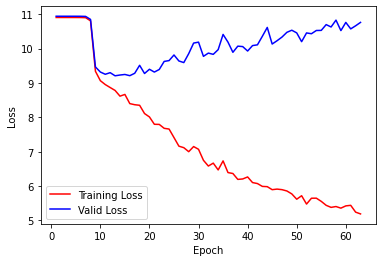

Early break! Best validation error: 9.15796246968894 at epoch 64


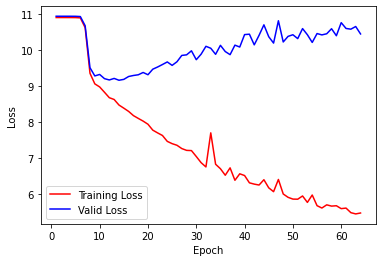

Early break! Best validation error: 9.221228075598717 at epoch 60


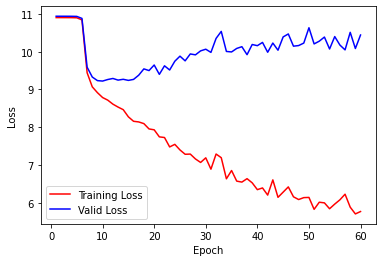

Early break! Best validation error: 9.179806713054367 at epoch 83


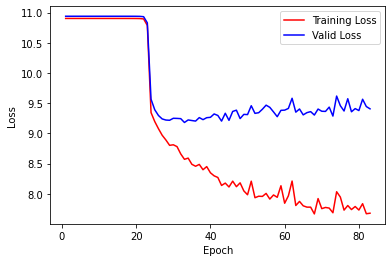

test rmse: 9.229721867828104


In [42]:
best_err = 10000
lr = 5e-3
for wd in wds:
    net = nn.Sequential()
    net.add(nn.Dense(45, activation="relu"))
    net.add(nn.Dense(45, activation="relu"))
    net.add(nn.Dense(1))
    net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
    train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain_demean[:10000], X_valid, Y_valid_demean, 3000, lr, 64, wd)
    
    if min(valid_loss) < best_err:
        best_err = min(valid_loss)
        test_rmse = rmse(Y_test_demean, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())
        
    epoch_count = range(1, len(train_loss) + 1)
    
    plt.plot(epoch_count, train_loss, 'r-')
    plt.plot(epoch_count, valid_loss, 'b-')
    plt.legend(['Training Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_dm_dropout
#### de-mean	10,000	MLP, two hidden layers + ReLu	Dropout

Early break! Best validation error: 9.130237865942068 at epoch 70


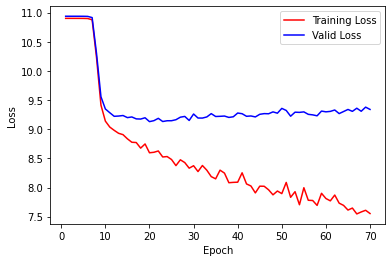

test rmse: 9.170668950195106


In [43]:
best_err = 10000
lr = 5e-3
net = nn.Sequential()
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(1))
net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain_demean[:10000], X_valid, Y_valid_demean, 3000, lr, 64)

test_rmse = rmse(Y_test_demean, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'r-')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_ykeep
#### keep	10,000	MLP, two hidden layers + ReLu	None

Early break! Best validation error: 10.938073859231247 at epoch 189


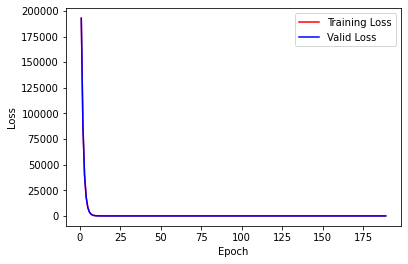

test rmse: 10.852446636325357


In [67]:
best_err = 10000
lr = 5e-3
net = nn.Sequential()
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dense(1))
net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain[:10000], X_valid, Y_valid, 3000, lr, 64)

test_rmse = rmse(Y_test, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'r-')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_ykeep_L2
#### keep	10,000	MLP, two hidden layers + ReLu	Weight Decay (L2)

Early break! Best validation error: 10.938075165496985 at epoch 65


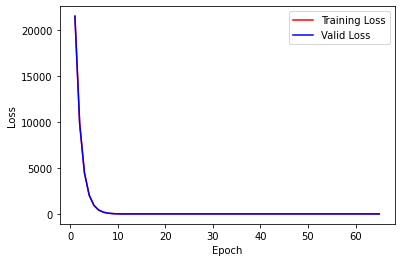

test rmse: 10.85239916911568


In [93]:
best_err = 10000
lr = 5e-3
wd = 2e-4
net = nn.Sequential()
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dense(1))
net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain[:10000], X_valid, Y_valid, 3000, lr, 64, wd)


test_rmse = rmse(Y_test, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'r-')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_ykeep_dropout
#### keep	10,000	MLP, two hidden layers + ReLu	Weight Decay (L2)

Early break! Best validation error: 64.29119230101674 at epoch 134


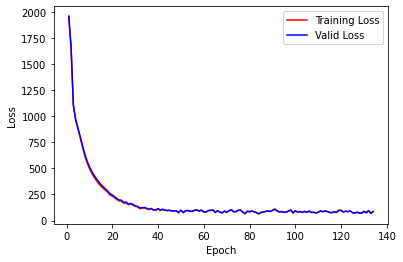

test rmse: 64.59579729718142


In [130]:
best_err = 10000
lr = 5e-4

net = nn.Sequential()
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(1))
net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
train_loss, valid_loss = train(net, X_subtrain[:10000], Y_subtrain[:10000], X_valid, Y_valid, 3000, lr, 64)

test_rmse = rmse(Y_test, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'r-')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'test rmse: {test_rmse}')

### MLP_2_dm_dropout_full
#### de-mean	All	MLP, two hidden layers + ReLu	Dropout

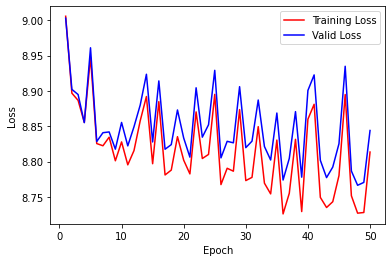

test rmse: 8.939116212345454


In [151]:
best_err = 10000
lr = 5e-3
net = nn.Sequential()
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(45, activation="relu"))
net.add(nn.Dropout(0.5))
net.add(nn.Dense(1))
net.collect_params().initialize(init.Normal(sigma=0.01), ctx=mx.gpu())
train_loss, valid_loss = train(net, X_subtrain, Y_subtrain_demean, X_valid, Y_valid_demean, 50, lr, 64, early_stop=False)

test_rmse = rmse(Y_test_demean, net(mx.ndarray.array(X_test, ctx=mx.gpu())).asnumpy())

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'r-')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'test rmse: {test_rmse}')

## Q2 (15%):

In [152]:
rmse_all = {'OLS': 9.558013246155223, 'MLP_0_dm': 9.553136340078291, 'MLP_1_dm': 9.245884554471074, 'MLP_2_dm': 9.215631217997048, 'MLP_2_dm_L2': 9.229721867828104, 'MLP_2_dm_dropout': 9.170668950195106, 'MLP_2_ykeep': 10.852446636325357, 'MLP_2_ykeep_L2': 10.85239916911568, 'MLP_2_ykeep_dropout': 64.29119230101674, 'MLP_2_dm_dropout_full': 8.939116212345454}

In [153]:
print ('{:<25} {:<15}'.format('Method','RMSE'))
for k, v in rmse_all.items():
    print ('{:<25} {:<15}'.format(k, v))

Method                    RMSE           
OLS                       9.558013246155223
MLP_0_dm                  9.553136340078291
MLP_1_dm                  9.245884554471074
MLP_2_dm                  9.215631217997048
MLP_2_dm_L2               9.229721867828104
MLP_2_dm_dropout          9.170668950195106
MLP_2_ykeep               10.852446636325357
MLP_2_ykeep_L2            10.85239916911568
MLP_2_ykeep_dropout       64.29119230101674
MLP_2_dm_dropout_full     8.939116212345454


### 由上表可以發現，linear model的表現大致相同。而non linear的部分，有demean過的結果表現都比linear model好，尤其是dropout的表現最好，可以推測在這個dataset上，non linear model的學習力更好一些。不過從loss plot來看，可以看出來隨著epoch變多，容易overfitting。而keep y的結果不盡理想，MLP_2_ykeep_dropout甚至梯度爆炸，設定grad clip後效果非常差。而使用全部train data的結果比使用部分來的好，符合預期。